In [5]:
import os
import pandas as pd
import numpy as np

# Caminhos das pastas de origem e destino
source_folder = "../datasets-by-source"
destination_folder = "../datasets-by-source-missing"

# Cria a pasta de destino, se não existir
os.makedirs(destination_folder, exist_ok=True)

# Lista de arquivos na pasta de origem
files = [f for f in os.listdir(source_folder) if f.endswith('.csv')]

# Função para substituir 15% dos dados por np.nan
def replace_with_nan(data, column_name, percentage):
    data = data.copy()
    n_missing = int(len(data) * percentage)
    missing_indices = np.random.choice(data.index, n_missing, replace=False)
    data.loc[missing_indices, column_name] = np.nan
    return data

# Processa cada arquivo na pasta de origem
for file in files:
    file_path = os.path.join(source_folder, file)
    df = pd.read_csv(file_path)

    # Remove as colunas especificadas, se existirem
    columns_to_remove = ["Link_bottleneck", "Unnamed: 0"]
    df = df.drop(columns=[col for col in columns_to_remove if col in df.columns], errors='ignore')

    # Substitui 15% dos dados nas colunas especificadas
    if 'Vazao' in df.columns:
        df = replace_with_nan(df, 'Vazao', 0.15)
    if 'Vazao_bbr' in df.columns:
        df = replace_with_nan(df, 'Vazao_bbr', 0.15)

    # Salva o dataset modificado na pasta de destino
    output_path = os.path.join(destination_folder, file)
    df.to_csv(output_path, index=False)

print("Processamento concluído. Os datasets foram salvos na pasta 'datasets-by-source-missing'.")


Processamento concluído. Os datasets foram salvos na pasta 'datasets-by-source-missing'.


In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

# Caminhos das pastas de origem e destino
source_folder = "../datasets-incomplete"
imputed_folder = "../datasets-by-source-imputed"
os.makedirs(imputed_folder, exist_ok=True)
subfolders = ["knn", "regression", "time-weighted"]
for subfolder in subfolders:
    os.makedirs(os.path.join(imputed_folder, subfolder), exist_ok=True)

# Função para imputar dados com KNN
def impute_with_knn(data, columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    data[columns] = imputer.fit_transform(data[columns])
    return data

# Função para imputar dados com regressão
def impute_with_regression(data, columns):
    data = data.copy()
    for column in columns:
        if data[column].isna().sum() > 0:
            not_nan = data[data[column].notna()]
            nan = data[data[column].isna()]
            if not_nan.shape[0] > 0:
                features = not_nan.drop(columns, axis=1).select_dtypes(include=[np.number])
                target = not_nan[column]
                model = LinearRegression()
                model.fit(features, target)
                predicted = model.predict(nan.drop(columns, axis=1).select_dtypes(include=[np.number]))
                data.loc[data[column].isna(), column] = predicted
    return data

# Função para imputar dados com média ponderada pelo tempo
def impute_with_time_weighted(data, columns, time_column):
    data = data.copy()
    for column in columns:
        if data[column].isna().sum() > 0:
            for idx in data[data[column].isna()].index:
                row_time = data.loc[idx, time_column]
                weighted_sum = 0
                weight_sum = 0
                for _, row in data[data[column].notna()].iterrows():
                    time_diff = abs(row[time_column] - row_time)
                    weight = 1 / (time_diff + 1e-9)
                    weighted_sum += weight * row[column]
                    weight_sum += weight
                data.loc[idx, column] = weighted_sum / weight_sum
    return data

# Processa cada arquivo na pasta de origem
files = [f for f in os.listdir(source_folder) if f.endswith('.csv')]
columns_to_impute = ["Vazao", "Vazao_bbr"]
time_column = "Timestamp_cubic"

for file in files:
    file_path = os.path.join(source_folder, file)
    df = pd.read_csv(file_path)

    # Imputação com KNN
    df_knn = impute_with_knn(df.copy(), columns_to_impute)
    knn_path = os.path.join(imputed_folder, "knn", file)
    df_knn.to_csv(knn_path, index=False)

    # Imputação com regressão
    df_regression = impute_with_regression(df.copy(), columns_to_impute)
    regression_path = os.path.join(imputed_folder, "regression", file)
    df_regression.to_csv(regression_path, index=False)

    # Imputação com média ponderada pelo tempo
    if time_column in df.columns:
        df_time_weighted = impute_with_time_weighted(df.copy(), columns_to_impute, time_column)
        time_weighted_path = os.path.join(imputed_folder, "time-weighted", file)
        df_time_weighted.to_csv(time_weighted_path, index=False)

print("Processamento concluído. Os datasets imputados foram salvos nas subpastas 'knn', 'regression' e 'time-weighted'.")


KeyboardInterrupt: 

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import Adam

# Função para imputar dados com ARIMA
def impute_with_arima(data, columns):
    data = data.copy()
    for column in columns:
        if data[column].isna().sum() > 0:
            series = data[column]
            series_filled = series.interpolate(method="linear")  # Inicializar com valores interpolados
            model = ARIMA(series_filled, order=(5, 1, 0))  # Parâmetros padrão (ajustar conforme necessário)
            model_fit = model.fit()
            forecast = model_fit.predict(start=0, end=len(series) - 1)
            data[column].fillna(pd.Series(forecast), inplace=True)
    return data

# Função para imputar dados com SARIMA
def impute_with_sarima(data, columns):
    data = data.copy()
    for column in columns:
        if data[column].isna().sum() > 0:
            series = data[column]
            series_filled = series.interpolate(method="linear")  # Inicializar com valores interpolados
            model = SARIMAX(series_filled, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            model_fit = model.fit(disp=False)
            forecast = model_fit.predict(start=0, end=len(series) - 1)
            data[column].fillna(pd.Series(forecast), inplace=True)
    return data

# Função para imputar dados com TCN
def impute_with_tcn(data, columns, time_steps=10):
    data = data.copy()
    for column in columns:
        if data[column].isna().sum() > 0:
            series = data[column].values
            series_filled = pd.Series(series).interpolate(method="linear").values
            
            # Preparar dados para TCN
            X, y = [], []
            for i in range(time_steps, len(series_filled)):
                if not np.isnan(series_filled[i]):
                    X.append(series_filled[i - time_steps:i])
                    y.append(series_filled[i])

            X, y = np.array(X), np.array(y)
            
            # Criar modelo TCN
            model = Sequential([
                Conv1D(64, kernel_size=2, activation='relu', input_shape=(time_steps, 1)),
                Flatten(),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
            
            # Treinar o modelo
            model.fit(X.reshape(-1, time_steps, 1), y, epochs=50, verbose=0)
            
            # Preencher valores faltantes
            for i in range(len(series)):
                if np.isnan(series[i]):
                    input_seq = series_filled[i - time_steps:i].reshape(1, time_steps, 1)
                    series[i] = model.predict(input_seq, verbose=0)[0][0]
            data[column] = series
    return data

# Processa cada arquivo na pasta de origem
files = [f for f in os.listdir(source_folder) if f.endswith('.csv')]
columns_to_impute = ["Vazao", "Vazao_bbr"]
time_column = "Timestamp"

for file in files:
    file_path = os.path.join(source_folder, file)
    df = pd.read_csv(file_path)

    # Imputação com KNN
    df_knn = impute_with_knn(df.copy(), columns_to_impute)
    knn_path = os.path.join(imputed_folder, "knn", file)
    df_knn.to_csv(knn_path, index=False)

    # Imputação com regressão
    df_regression = impute_with_regression(df.copy(), columns_to_impute)
    regression_path = os.path.join(imputed_folder, "regression", file)
    df_regression.to_csv(regression_path, index=False)

    # Imputação com média ponderada pelo tempo
    if time_column in df.columns:
        df_time_weighted = impute_with_time_weighted(df.copy(), columns_to_impute, time_column)
        time_weighted_path = os.path.join(imputed_folder, "time-weighted", file)
        df_time_weighted.to_csv(time_weighted_path, index=False)

    # Imputação com ARIMA
    df_arima = impute_with_arima(df.copy(), columns_to_impute)
    arima_path = os.path.join(imputed_folder, "arima", file)
    df_arima.to_csv(arima_path, index=False)

    # Imputação com SARIMA
    df_sarima = impute_with_sarima(df.copy(), columns_to_impute)
    sarima_path = os.path.join(imputed_folder, "sarima", file)
    df_sarima.to_csv(sarima_path, index=False)

    # Imputação com TCN
    df_tcn = impute_with_tcn(df.copy(), columns_to_impute)
    tcn_path = os.path.join(imputed_folder, "tcn", file)
    df_tcn.to_csv(tcn_path, index=False)

print("Processamento concluído. Os datasets imputados foram salvos nas subpastas específicas.")


c:\Users\macla\Documents\Projetos Dev\CTGAN\ctgan_code\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: cannot reshape array of size 0 into shape (1,10,1)

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error


subfolders = ["knn", "regression", "time-weighted", "gan"]


def calculate_rmse(original_folder, imputed_folder, columns):
    results = []
    original_files = [f for f in os.listdir(original_folder) if f.endswith('.csv')]
    for method in subfolders:
        print(method)
        method_folder = os.path.join(imputed_folder, method)
        if not os.path.exists(method_folder):
            continue

        for file in original_files:
            original_path = os.path.join(original_folder, file)
            imputed_path = os.path.join(method_folder, file)

            if os.path.exists(imputed_path):
                original_df = pd.read_csv(original_path)
                imputed_df = pd.read_csv(imputed_path)

                for column in columns:
                    if column in original_df.columns and column in imputed_df.columns:
                        original_values = original_df[column].dropna()
                        imputed_values = imputed_df.loc[original_values.index, column].fillna(0) 

                        valid_rows = imputed_values.notna()
                        original_values = original_values[valid_rows]
                        imputed_values = imputed_values[valid_rows]

                        rmse = np.sqrt(mean_squared_error(original_values, imputed_values))
                        results.append({"Method": method, "File": file, "Column": column, "RMSE": rmse})

    return pd.DataFrame(results)


original_folder = "../datasets-by-source"
imputed_folder = "../datasets-by-source-imputed"
columns_to_evaluate = ["Vazao", "Vazao_bbr"]

# Calcula e salva os resultados do RMSE
rmse_results = calculate_rmse(original_folder, imputed_folder, columns_to_evaluate)
rmse_results.to_csv("rmse_results.csv", index=False)

print("RMSE calculado e salvo em 'rmse_results.csv'.")

knn
regression
time-weighted
gan
RMSE calculado e salvo em 'rmse_results.csv'.


C:\Users\macla\AppData\Local\Temp\ipykernel_19736\2315452802.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Method')
C:\Users\macla\AppData\Local\Temp\ipykernel_19736\2315452802.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Method')



Summary Statistics:
                              mean           std          min           max
Method     Column                                                          
gan        Vazao      3.175364e+08  3.247527e+08  70193422.06  1.110943e+09
           Vazao_bbr  3.022744e+08  3.809086e+08  27795604.62  1.079557e+09
knn        Vazao      1.838044e+08  1.698785e+08  66007906.57  6.591006e+08
           Vazao_bbr  1.684515e+08  1.992050e+08  26024477.48  5.655802e+08
regression Vazao      2.255903e+08  2.541741e+08  65204157.95  9.167853e+08
           Vazao_bbr  2.223230e+08  2.924976e+08  24260936.53  8.542905e+08

Best performing methods by state and column:
         File     Column      Method          RMSE
0   df_ac.csv      Vazao         knn  7.798975e+07
49  df_ac.csv  Vazao_bbr  regression  3.399007e+07
50  df_am.csv      Vazao  regression  1.369709e+08
3   df_am.csv  Vazao_bbr         knn  4.153563e+07
52  df_ap.csv      Vazao  regression  8.946515e+07
53  df_ap.csv  Vaza

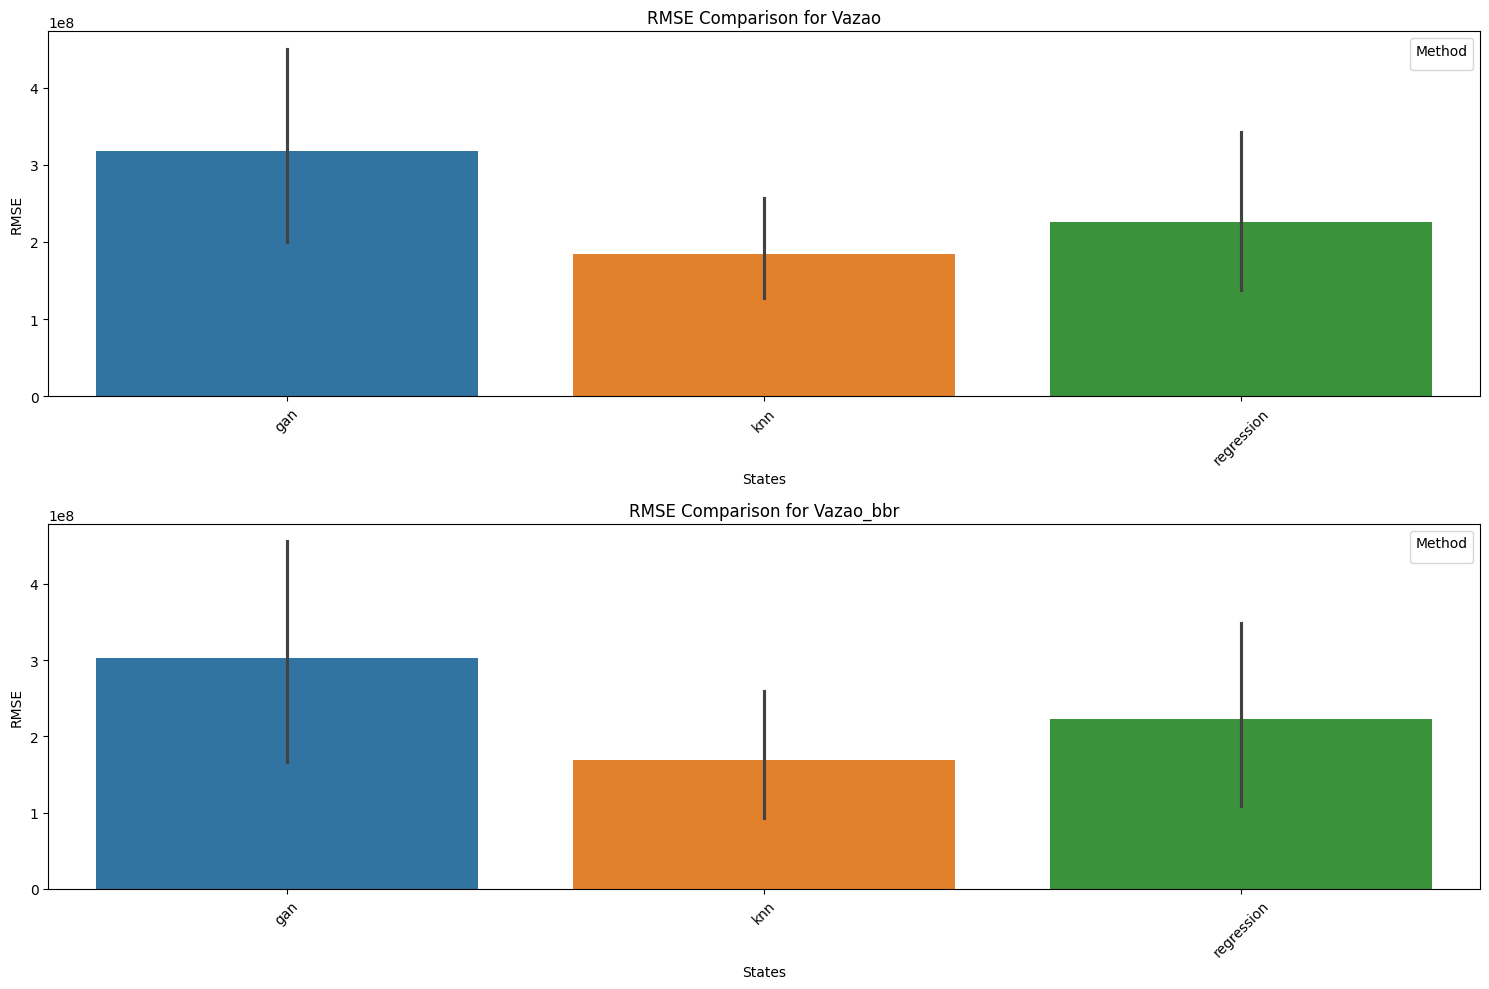

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('rmse_results.csv')

# Create a figure with two subplots, one for each column (Vazao and Vazao_bbr)
plt.figure(figsize=(15, 10))

# Plot for Vazao
plt.subplot(2, 1, 1)
vazao_data = df[df['Column'] == 'Vazao'].pivot(index='File', columns='Method', values='RMSE')
sns.barplot(data=vazao_data)
plt.title('RMSE Comparison for Vazao')
plt.xlabel('States')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.legend(title='Method')

# Plot for Vazao_bbr
plt.subplot(2, 1, 2)
vazao_bbr_data = df[df['Column'] == 'Vazao_bbr'].pivot(index='File', columns='Method', values='RMSE')
sns.barplot(data=vazao_bbr_data)
plt.title('RMSE Comparison for Vazao_bbr')
plt.xlabel('States')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.legend(title='Method')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('imputation_comparison.png', dpi=300, bbox_inches='tight')

# Calculate summary statistics
summary_stats = df.groupby(['Method', 'Column'])['RMSE'].agg(['mean', 'std', 'min', 'max']).round(2)
print("\nSummary Statistics:")
print(summary_stats)

# Find best performing method for each state and column
best_methods = df.loc[df.groupby(['File', 'Column'])['RMSE'].idxmin()]
print("\nBest performing methods by state and column:")
print(best_methods[['File', 'Column', 'Method', 'RMSE']])

# Save summary to a text file
with open('imputation_analysis.txt', 'w') as f:
    f.write("Summary Statistics:\n")
    f.write(summary_stats.to_string())
    f.write("\n\nBest performing methods by state and column:\n")
    f.write(best_methods[['File', 'Column', 'Method', 'RMSE']].to_string())

In [20]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.3-cp312-cp312-win_amd64.whl.metadata (168 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.1.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.55.3-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
Using cached pillow-11.1.0-cp312-cp312-win_amd64.whl (2.6 MB)
U